# Model Training for 

1) Data preprocessing
2) Baseline Model
3) Fine Tuning BERT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import nltk
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [63]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/valid.csv')
test, valid = train_test_split(test, test_size=0.5, random_state=42)

# save first tag into Tag column
train['Tag'] = train['Tags'].apply(lambda x: [tag for tag in x[1:-1].split('><') if tag][0])
valid['Tag'] = valid['Tags'].apply(lambda x: [tag for tag in x[1:-1].split('><') if tag][0])
test['Tag'] = test['Tags'].apply(lambda x: [tag for tag in x[1:-1].split('><') if tag][0])

print(f"train:\t{len(train)} rows ({len(train) / (len(train) + len(valid) + len(test)) * 100}%)")
print(f"valid:\t{len(valid)} rows ({len(valid) / (len(train) + len(valid) + len(test)) * 100}%)")
print(f"test:\t{len(test)} rows ({len(test) / (len(train) + len(valid) + len(test)) * 100}%)")

train:	45000 rows (75.0%)
valid:	7500 rows (12.5%)
test:	7500 rows (12.5%)


In [3]:
train.head()

,Id,Title,Body,Tags,CreationDate,Y,Tag
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,java
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ,java
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,javascript
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,swift
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ,android


In [4]:
# check for missing values
train.isna().sum()

Id              0
Title           0
Body            0
Tags            0
CreationDate    0
Y               0
Tag             0
dtype: int64

1348 unique tags


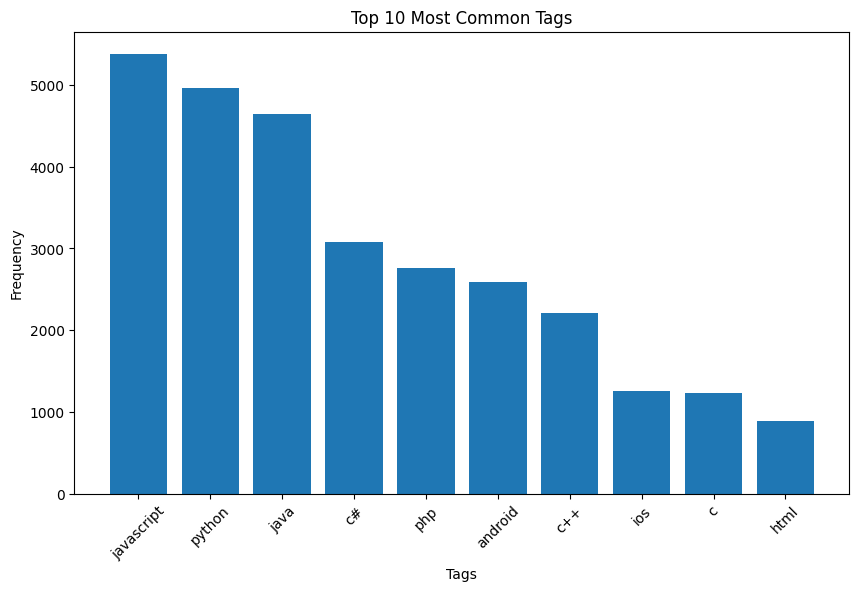

In [5]:
# Counting the frequency of each tag
tag_counts = Counter(train['Tag'])

# Getting the most common tags
most_common_tags = tag_counts.most_common(10)  # Adjust the number as needed
print(f"{len(tag_counts)} unique tags")

# Plotting
tags, counts = zip(*most_common_tags)
plt.figure(figsize=(10, 6))
plt.bar(tags, counts)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Tags')
plt.xticks(rotation=45)
plt.show()

Max Title length = 33


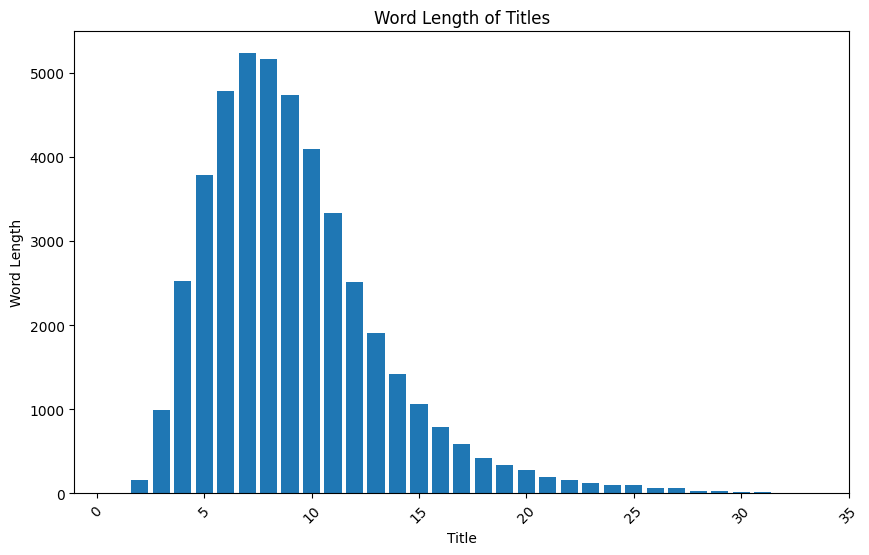

In [6]:
word_length = train['Title'].apply(lambda x: len(x.split()))
word_length = Counter(word_length)

max_length = max(word_length.keys())

print (f"Max Title length = {max_length}")
plt.figure(figsize=(10, 6))
plt.bar(word_length.keys(), word_length.values())
plt.xlabel('Title')
plt.ylabel('Word Length')
plt.title('Word Length of Titles')
plt.xticks(rotation=45)
plt.show()

# Baseline Model

In [138]:
import time
from transformers import BertTokenizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB

In [135]:
# Encoding the labels
label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([train['Tag'], valid['Tag'], test['Tag']]))

X_train = pd.concat([train['Title'], valid['Title']])
y_train = label_encoder.transform(pd.concat([train['Tag'], valid['Tag']]))

X_test = test['Title']
y_test = label_encoder.transform(test['Tag'])

In [136]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

In [139]:
# Train the model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [144]:
# Predictions
y_pred = nb_model.predict(X_test)

# Calculate metrics
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"F1 Score: {f1:.3}")
print(f"Precision: {precision:.3}")
print(f"Recall: {recall:.3}")

F1 Score: 0.291
Precision: 0.355
Recall: 0.381


# fine tune BERT

In [146]:
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, AutoTokenizer
from copy import deepcopy
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import pickle

In [67]:
class TagDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_encoder, tokenizer, max_length):
        self.len = len(dataframe)
        self.data = dataframe
        self.data['Tag'] = label_encoder.transform(self.data['Tag'])
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, index):
        title = str(self.data['Title'][index])
        tag = self.data['Tag'][index]

        # Tokenize the title
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(tag, dtype=torch.long)
        }

    def __len__(self):
        return self.len

label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([train['Tag'], valid['Tag'], test['Tag']]))

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_df = deepcopy(train).reset_index(drop=True)
valid_df = deepcopy(valid).reset_index(drop=True)
test_df = deepcopy(test).reset_index(drop=True)

# Create dataloaders
train_loader = DataLoader(TagDataset(train_df, label_encoder, tokenizer, max_length), batch_size=32, shuffle=True)
valid_loader = DataLoader(TagDataset(valid_df, label_encoder, tokenizer, max_length), batch_size=32)
test_loader = DataLoader(TagDataset(test_df, label_encoder, tokenizer, max_length), batch_size=32)

In [30]:
def train_model(model, train_loader, valid_loader, optimizer, loss_fn, epochs, device):
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            # Move batch to device
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)

            # Forward pass
            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss = outputs.loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Average Training Loss for Epoch {epoch+1}: {avg_loss}")

        # Validation
        evaluate_model(model, valid_loader, loss_fn, device)

In [31]:
def evaluate_model(model, data_loader, loss_fn, device):
    model.eval()
    total_loss, total_accuracy = 0, 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            # Move batch to device
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)

            # Forward pass
            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss = outputs.loss
            total_loss += loss.item()

            # Compute accuracy
            preds = torch.argmax(outputs.logits, dim=1)
            total_accuracy += (preds == targets).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = total_accuracy / (len(data_loader.dataset))

    print(f"Validation Loss: {avg_loss}")
    print(f"Validation Accuracy: {accuracy}")

In [32]:
num_unique_tags = len(set(pd.concat([train['Tag'], valid['Tag'], test['Tag']])))
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_unique_tags)

optimizer = AdamW(model.parameters(), lr=5e-5)

loss_fn = nn.CrossEntropyLoss()

epochs = 4

device = torch.device("cpu")

train_model(model, train_loader, valid_loader, optimizer, loss_fn, epochs, device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/4: 100%|███████████████████████████████████████████████████████| 1407/1407 [47:04<00:00,  2.01s/it]


Average Training Loss for Epoch 1: 2.9040516761489683


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 235/235 [02:13<00:00,  1.76it/s]


Validation Loss: 2.2458874524907864
Validation Accuracy: 0.5396


Training Epoch 2/4: 100%|███████████████████████████████████████████████████████| 1407/1407 [49:35<00:00,  2.11s/it]


Average Training Loss for Epoch 2: 2.009959532084326


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 235/235 [02:16<00:00,  1.72it/s]


Validation Loss: 2.0474727947661218
Validation Accuracy: 0.5648


Training Epoch 3/4: 100%|███████████████████████████████████████████████████████| 1407/1407 [50:36<00:00,  2.16s/it]


Average Training Loss for Epoch 3: 1.660893373440239


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 235/235 [02:22<00:00,  1.65it/s]


Validation Loss: 2.040106731526395
Validation Accuracy: 0.5750666666666666


Training Epoch 4/4: 100%|███████████████████████████████████████████████████████| 1407/1407 [52:35<00:00,  2.24s/it]


Average Training Loss for Epoch 4: 1.3718146429514326


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 235/235 [03:12<00:00,  1.22it/s]

Validation Loss: 2.0913253122187676
Validation Accuracy: 0.5730666666666666


In [33]:
# # Save the model and tokenizer
# model.save_pretrained('fine-tuned-model')
# tokenizer.save_pretrained('bert-tokenizer')
# with open('label_encoder.pkl', 'wb') as file:
#     pickle.dump(label_encoder, file)

('bert-tokenizer/tokenizer_config.json',
 'bert-tokenizer/special_tokens_map.json',
 'bert-tokenizer/vocab.txt',
 'bert-tokenizer/added_tokens.json')

In [147]:
# # load model
model = AutoModelForSequenceClassification.from_pretrained('fine-tuned-model')
tokenizer = AutoTokenizer.from_pretrained('bert-tokenizer')
with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

In [148]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

def predict(model, test_loader, device):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(input_ids=ids, attention_mask=mask)
            preds = torch.argmax(outputs.logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())

    return np.array(predictions), np.array(true_labels)


In [149]:
predictions, true_labels = predict(model, test_loader, device)

# Calculate metrics
f1 = f1_score(true_labels, predictions, average='weighted')
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')

print(f"F1 Score: {f1:.3}")
print(f"Precision: {precision:.3}")
print(f"Recall: {recall:.3}")

F1 Score: 0.547
Precision: 0.532
Recall: 0.578


# Pruning

In [150]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('fine-tuned-model')

In [151]:
import torch.nn.utils.prune as prune

for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.5)

for module in model.modules():
    if isinstance(module, torch.nn.Linear):
        prune.remove(module, 'weight')

In [152]:
model.save_pretrained('fine-tuned-model-prune')

In [153]:
predictions, true_labels = predict(model, test_loader, device)

# Calculate metrics
f1 = f1_score(true_labels, predictions, average='weighted')
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')

print(f"F1 Score: {f1:.3}")
print(f"Precision: {precision:.3}")
print(f"Recall: {recall:.3}")

F1 Score: 0.534
Precision: 0.519
Recall: 0.573


# Quantization

In [170]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('fine-tuned-model')

In [171]:
from torch.quantization import quantize_dynamic

quantized_model = quantize_dynamic(
    model, 
    {torch.nn.Linear},
    dtype=torch.qint8
)

In [174]:
predictions, true_labels = predict(quantized_model, test_loader, device)

# Calculate metrics
f1 = f1_score(true_labels, predictions, average='weighted')
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')

print(f"F1 Score: {f1:.3}")
print(f"Precision: {precision:.3}")
print(f"Recall: {recall:.3}")

F1 Score: 0.533
Precision: 0.525
Recall: 0.57


# Prune and Quantization

In [176]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('fine-tuned-model')

In [180]:
import torch.nn.utils.prune as prune
from torch.quantization import quantize_dynamic

for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.5)

for module in model.modules():
    if isinstance(module, torch.nn.Linear):
        prune.remove(module, 'weight')

model_prune_quant = quantize_dynamic(
    model, 
    {torch.nn.Linear},
    dtype=torch.qint8
)

In [178]:
predictions, true_labels = predict(model, test_loader, device)

# Calculate metrics
f1 = f1_score(true_labels, predictions, average='weighted')
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')

print(f"F1 Score: {f1:.3}")
print(f"Precision: {precision:.3}")
print(f"Recall: {recall:.3}")

F1 Score: 0.416
Precision: 0.491
Recall: 0.452


# Predict Tag

In [129]:
def predict_tag(title, model, tokenizer, label_encoder, max_length, device):
    # Tokenize and prepare the input text
    inputs = tokenizer.encode_plus(
        title,
        None,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True
    )
    
    ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0).to(device)
    mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0).to(device)

    # Get the model prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=ids, attention_mask=mask)
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()

    # Decode the prediction
    predicted_tag = label_encoder.inverse_transform(prediction)[0]

    return predicted_tag

predict_tag("Hi. I'm a Title", model, tokenizer, label_encoder, max_length, device)

'javascript'

In [158]:
def time_predictions(model, titles, tokenizer, label_encoder, max_length, device, num_iterations=10):
    total_time = 0
    for _ in range(num_iterations):
        for title in titles:
            start_time = time.time()
            predict_tag(title, model, tokenizer, label_encoder, max_length, device)
            total_time += time.time() - start_time

    average_time = total_time / (len(titles) * num_iterations)
    return average_time

In [181]:
model = AutoModelForSequenceClassification.from_pretrained('fine-tuned-model')
model_prune = AutoModelForSequenceClassification.from_pretrained('fine-tuned-model-prune')

In [184]:
sample_titles = [f"{i}. example question and some random words" for i in range(10)]

standard_model_time = time_predictions(model, sample_titles, tokenizer, label_encoder, max_length, device)
pruned_model_time = time_predictions(model_prune, sample_titles, tokenizer, label_encoder, max_length, device)
quantized_model_time = time_predictions(quantized_model, sample_titles, tokenizer, label_encoder, max_length, device)
p_q_model_time = time_predictions(model_prune_quant, sample_titles, tokenizer, label_encoder, max_length, device)

print(f"Standard Model Average Time: {standard_model_time:.4}")
print(f"Pruned Model Average Time: {pruned_model_time:.4}")
print(f"Quantized Model Average Time: {quantized_model_time:.4}")
print(f"Pruned and Quantized Model Average Time: {p_q_model_time:.4}")

Standard Model Average Time: 0.03564
Pruned Model Average Time: 0.03585
Quantized Model Average Time: 0.01874
Pruned and Quantized Model Average Time: 0.01954
